# E11. 프로젝트: 뉴스기사 요약해보기

**루브릭**  

|평가문항 |	상세기준|  
|:-------------|:---------| 
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|  
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. | 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|  
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

[참고](https://wikidocs.net/72820) 

## Step 0. 필요한 모듈 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel-d34j/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.  
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)



In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

# 파일 이동
!mv news_summary_more.csv ~/aiffel/news_summarization/data

In [3]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv", encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
29960,CSK's Dwayne Bravo produces diving catch off o...,CSK all-rounder Dwayne Bravo pulled off a divi...
52972,"Builders diverted homebuyers' Ã¢ÂÂ¹1,000 cror...",The Yamuna Expressway Industrial Development A...
67298,NCP holds rail roko to condemn Elphinstone sta...,Nationalist Congress Party (NCP) supporters le...
1552,MS Dhoni is a superstar and an all-time great:...,"Talking about MS Dhoni, who slammed three cons..."
38223,Afghanistan last just 27.5 overs in 1st inning...,Afghanistan were dismissed for just 109 runs i...
2354,Kohli gets out for single digit score in an OD...,Team India captain Virat Kohli was dismissed c...
13536,Drug peddlers make money in Goa EDM fests: Shi...,The Goa unit of Shiv Sena has opposed Electron...
10955,Delhi CM acquitted in defamation case filed by...,A Delhi court on Monday acquitted CM Arvind Ke...
53109,Bitcoin not a way to evade tax: Unocoin Founder,Indian Bitcoin exchange Unocoin's Co-founder S...
35610,Somveer wins India's 12th wrestling medal at C...,Indian wrestler Somveer won a bronze medal at ...


* 이 데이터는 기사의 본문에 해당되는 **text와 headlines** 두 가지 열로 구성되어져 있습니다.

* <span style='color:red'> **추상적 요약**</span>을 하는 경우에는 **text를 본문**, **headlines를 이미 요약된 데이터**로 삼아서 모델을 학습할 수 있어요.   
* <span style='color:blue'>**추출적 요약**</span>을 하는 경우에는 오직 **text열만을 사용**하세요.


## Step 2. 데이터 전처리하기 (추상적 요약)

* 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 **전처리**를 추가 사용하여 텍스트를 **정규화** 또는 **정제**해 보세요. 
* 만약, **불용어 제거**를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

### Step 2-1. 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
# 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 중복된 text 데이터 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


* 98401 - 98360 = 41 개 제거됨

In [7]:
# Null 값이 있는지 확인하고 갯수 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


###  Step 2-2. 텍스트 정규화와 불용어 제거

In [8]:
# 텍스트 정규화를 위한 사전(dictionary) 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
# NLTK에서 미리 정의하여 제공하고 있는 불용어 리스트
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()                       # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text   # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)     # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)               # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)            # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)     # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)      # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전체 text 데이터에 대한 전처리 
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))  # 불용어 제거함

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
# 전체 headlines 데이터에 대한 전처리 
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))  # 불용어 제거하지 않음

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
# 데이터프레임에 재저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### Step 2-3. 훈련 데이터와 테스트 데이터 나누기

#### Step 2-3-1. 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


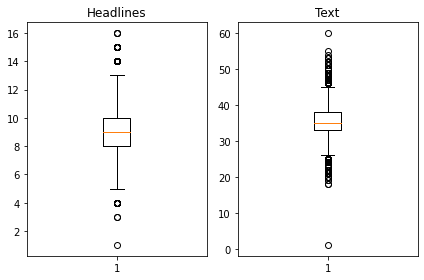

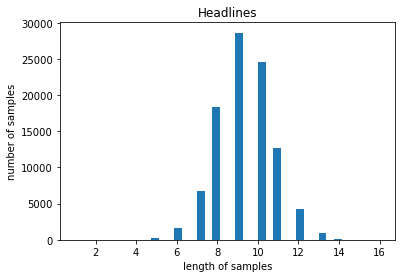

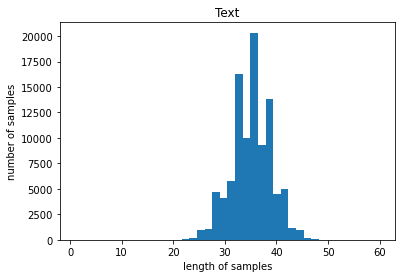

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* text의 경우 최소 길이가 1, 최대 길이가 60이고, 평균 길이는 35
* text의 시각화 된 그래프로 봤을 때는 대체적으로는 25~45 내외의 길이를 가진다는 것을 확인할 수 있어요.

* headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧아요.
* headlines의 그래프로 봤을 때에 대체적으로 12이하의 길이를 가지고 있네요.

In [16]:
# text의 최대 길이와 headlines 적절한 최대 길이 설정
text_max_len = 42
headlines_max_len = 11 

In [17]:
# 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt / len(nested_list)}')

In [18]:
# 몇 %의 샘플까지 포함하는지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


* text 열의 경우 약 2.5%, headlines 열의 경우 약 5.5% 정도가 훈련 데이터에 포함되 않는다.

In [19]:
# 정해진 길이보다 길면 제외하는 방법으로 데이터 정제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('1차 정제 후 전체 샘플수 :',(len(data)))
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('2차 정제 후 전체 샘플수 :',(len(data)))

1차 정제 후 전체 샘플수 : 95904
2차 정제 후 전체 샘플수 : 90643


#### Step 2-3-2. 시작 토큰과 종료 토큰 추가하기

In [20]:
#요약(headlines) 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)     # 시작 토큰 추가
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')   # 종료 토큰 추가
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text'])             # 인코더의 입력
decoder_input = np.array(data['decoder_input'])    # 디코더의 입력
decoder_target = np.array(data['decoder_target'])  # 디코더의 레이블

#### Step 2-3-3. 훈련 데이터와 테스트 데이터 분리

In [22]:
# encoder_input과 크기와 형태가 같으며 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])   # 90643 미만의 값으로 구성됨
np.random.shuffle(indices)
print(indices)

[22239 26478  9115 ... 18720 78248 79851]


In [23]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해줘 잘 섞인 샘플 만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18128


In [25]:
# 분할된 테스트 데이터의 갯수를 이용해 전체 데이터를 양분하기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 72515
훈련 레이블의 개수 : 72515
테스트 데이터의 개수 : 18128
테스트 레이블의 개수 : 18128


### Step 2-4. 정수 인코딩

#### Step 2-4-1. 인코더 단어 집합(vocaburary) 만들기

In [26]:
# 입력된 훈련 데이터로부터 단어 집합을 만들기
src_tokenizer = Tokenizer()                       # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)   # 입력된 데이터로부터 단어 집합 생성

* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요.
* 생성된 단어 집합은 src_tokenizer.**word_index**에 **저장**되어있어요.
* 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.


* 등장 빈도수가 7 회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

* src_tokenizer.**word_counts.items()** 에는 **단어와 각 단어의 등장 빈도수가 저장**되어져 있는데, 
* 이를 통해서 통계적인 정보를 얻을 수 있어요

In [27]:
# 단어와 각 단어의 등장 빈도수의 통계적인 정보
threshold = 7
total_cnt = len(src_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f'단어 집합(vocabulary)의 크기 : {total_cnt}')
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}')
print(f'단어 집합에서 희귀 단어의 비율: {(rare_cnt / total_cnt)*100}')
print(f'전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {(rare_freq / total_freq)*100}')

단어 집합(vocabulary)의 크기 : 67142
등장 빈도가 6번 이하인 희귀 단어의 수: 45878
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21264
단어 집합에서 희귀 단어의 비율: 68.32980846563999
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.677186666756218


* encoder_input_train에는 총 67,003개의 단어가 있네요. 

* 등장 빈도가 threshold 값인 7회 미만인 단어들은 단어 집합에서 무려 68% 이상을 차지하네요.

* 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.66%밖에 되지 않아요.

* 그래서 등장 빈도가 7회 미만인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.

* 희귀단어를 제외한 단어 집합의 크기를 21,292으로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한해볼게요.

#### Step 2-4-2.  인코더 정수 인코딩

In [28]:
# 토크나이저 객체 생성 및 단어 집합 재생성
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab)   # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)    # 단어 집합 재생성.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[207, 313, 89, 2887, 165, 1617, 12, 23, 399, 25, 32, 62, 4228, 1410, 1628, 11974, 254, 100, 47, 3519, 181, 1116, 102, 1447, 5061, 1804, 4639, 349, 5112, 765, 1287], [170, 22, 607, 233, 305, 1622, 1698, 102, 623, 1079, 4728, 6850, 207, 33, 32, 6, 1470, 881, 1699, 2067, 2318, 1459, 60, 1575, 326, 9389, 14097, 196, 563], [7716, 2011, 920, 59, 1326, 2676, 968, 1419, 7717, 199, 10973, 619, 1334, 2294, 151, 765, 2265, 275, 224, 620, 18651, 262, 10, 620, 482, 259, 856, 43, 1]]


#### Step 2-4-3. 디코더 단어 집합(vocaburary) 만들기

In [30]:
# 토크나이저 객체 생성 및 단어 집합 생성
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
# 단어와 각 단어의 등장 빈도수의 통계적인 정보
threshold = 7
total_cnt = len(tar_tokenizer.word_index)     # 단어의 수
rare_cnt = 0                                  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                                # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                                 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f'단어 집합(vocabulary)의 크기 : {total_cnt}')
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}')
print(f'단어 집합에서 희귀 단어의 비율: {(rare_cnt / total_cnt)*100}')
print(f'전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {(rare_freq / total_freq)*100}')

단어 집합(vocabulary)의 크기 : 29205
등장 빈도가 6번 이하인 희귀 단어의 수: 20055
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9150
단어 집합에서 희귀 단어의 비율: 68.66974833076527
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.701830839375303


* 등장 빈도가 7회 미만인 단어들은 단어 집합에서 약 69%를 차지하고있네요.
* 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.72%밖에 되지 않아요.
* 아까 했던것과 동일하게 이 단어들은 모두 제거할게요. 9,151에서 어림잡아 9,000을 단어 집합의 크기로 제한할게요.

#### Step 2-4-4. 디코더 정수 인코딩

In [32]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 896, 2619, 252, 54, 10, 384, 3], [1, 87, 394, 461, 85, 4442, 136, 6, 419, 5568], [1, 27, 110, 261, 11, 1525, 58, 5338, 24], [1, 5569, 3106, 9, 38, 825, 3, 3281, 4164], [1, 50, 2127, 7349, 563, 743, 5570]]
target
decoder  [[896, 2619, 252, 54, 10, 384, 3, 2], [87, 394, 461, 85, 4442, 136, 6, 419, 5568, 2], [27, 110, 261, 11, 1525, 58, 5338, 24, 2], [5569, 3106, 9, 38, 825, 3, 3281, 4164, 2], [50, 2127, 7349, 563, 743, 5570, 2]]


input
input  [[1, 249, 90, 1068, 13, 440, 3, 15, 461, 7, 1837], [1, 1450, 79, 341, 5, 26, 22, 25, 117], [1, 42, 60, 151, 5, 882], [1, 58, 4, 1725, 6, 15], [1, 249, 19, 1919, 1001, 636, 702]]
target
decoder  [[249, 90, 1068, 13, 440, 3, 15, 461, 7, 1837, 2], [1450, 79, 341, 5, 26, 22, 25, 117, 2], [42, 60, 151, 5, 882, 2], [58, 4, 1725, 6, 15, 2], [249, 19, 1919, 1001, 636, 702, 2]]

In [33]:
# 요약문의 길이가 1인 경우 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test  = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 72514
훈련 레이블의 개수 : 72514
테스트 데이터의 개수 : 18128
테스트 레이블의 개수 : 18128


/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Step 2-5. 패딩하기

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test  = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

decoder_input_train  = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')

decoder_input_test  = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

* 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
* 실습 내용을 참고하여 **어텐션 메커니즘을 사용한 seq2seq를 설계**해 보세요.

### Step 3-1. 인코더 설계

In [35]:
# 함수형 API를 이용해서 인코더 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb_layer = Embedding(src_vocab, embedding_dim)   # (input_dim, output_dim)
enc_emb = enc_emb_layer(encoder_inputs)
# enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)   # 한줄로 표현

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, 
                     return_sequences=True,   # 각 time step별 hidden state를 모두 출력하게 된다
                     return_state=True ,      # 마지막 time step에서의 output(hidden state), hidden state와 cell state가 출력된다
                     dropout = 0.4, 
                     recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, 
                     return_sequences=True, 
                     return_state=True, 
                     dropout=0.4, 
                     recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, 
                     return_state=True, 
                     return_sequences=True, 
                     dropout=0.4, 
                     recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### Step 3-2. 디코더 설계

In [36]:
# 함수형 API를 이용해서 디코더 설계

# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, 
                    return_sequences = True, 
                    return_state = True, 
                    dropout = 0.4, 
                    recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, 
                                     initial_state = [state_h, state_c])

In [37]:
# # 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# # 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()

* 디코더의 출력층 설계를 어텐션 메커니즘으로 바꿔서 성능을 높이는 방법

### Step 3-3. 어텐션 매커니즘 설계

In [38]:
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Step 3-4. 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

modhist = model.fit(x = [encoder_input_train, decoder_input_train], 
                    y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, 
                    callbacks=[es], 
                    epochs = 50)

Epoch 1/50
284/284 [==============================] - 86s 302ms/step - loss: 5.9327 - val_loss: 5.5047
Epoch 2/50
284/284 [==============================] - 85s 300ms/step - loss: 5.3573 - val_loss: 5.1292
Epoch 3/50
284/284 [==============================] - 85s 300ms/step - loss: 5.0075 - val_loss: 4.8469
Epoch 4/50
284/284 [==============================] - 85s 299ms/step - loss: 4.7136 - val_loss: 4.6294
Epoch 5/50
284/284 [==============================] - 85s 300ms/step - loss: 4.4883 - val_loss: 4.4725
Epoch 6/50
284/284 [==============================] - 85s 301ms/step - loss: 4.3011 - val_loss: 4.3686
Epoch 7/50
284/284 [==============================] - 85s 299ms/step - loss: 4.1413 - val_loss: 4.2492
Epoch 8/50
284/284 [==============================] - 86s 304ms/step - loss: 4.0038 - val_loss: 4.1748
Epoch 9/50
284/284 [==============================] - 87s 307ms/step - loss: 3.8824 - val_loss: 4.1069
Epoch 10/50
284/284 [==============================] - 87s 307ms/step - l

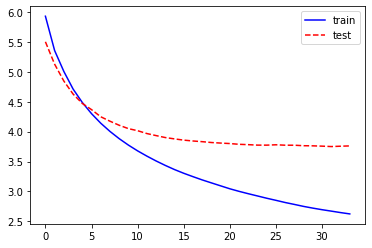

In [40]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(modhist.history['loss'], 'b-', label='train')
plt.plot(modhist.history['val_loss'], 'r--', label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

* 원래의 요약문(headlines 열)과 학습을 통해 얻은 **추상적 요약의 결과를 비교**해보세요.

### Step 4-1. 인퍼런스 모델 구현하기

In [41]:
# 정수 인덱스 데이터를 실제 데이터로 복원하는데 필요한 3개의 사전 준비
src_index_to_word = src_tokenizer.index_word   # 원문 단어 집합에서 정수로부터 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index   # 요약 단어 집합에서 단어로부터 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word   # 요약 단어 집합에서 정수로부터 단어를 얻음

#### Step 4-1-1. 인코더 모델 설계

In [42]:
# 인코더 모델 설계
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])

#### Step 4-1-2. 디코더 모델 설계

In [43]:
# 어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### Step 4-1-3. 단어 시퀀스를 완성하는 함수

In [44]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4-2. 모델의 요약문 비교하기

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [46]:
# 테스트 데이터 약 10개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bangladeshi origin suspect set homemade bomb new york monday reportedly told investigators carried attack retaliation us air strikes isis targets syria elsewhere us authorities believe got self radicalised likely watching terror group propaganda internet 
실제 요약 : ny bomb attack in revenge of attacks on isis suspect 
예측 요약 :  indian origin man killed in syria after isis attack


원문 : year old national bravery award recipient khan designated special police officer agra police uttar pradesh khan awarded bravery award taking active measures network drugs gambling rackets filed numerous police complaints also instrumental stopping kidnapping attempt six year old 
실제 요약 : bravery award winner special police officer in up 
예측 요약 :  phogat son booked for raping derogatory award


원문 : maharashtra state road transport corporation decided deduct days salaries staffers four day strike diwali staffers receive days salaries next six months notice issued said comes bombay high court declared st

## Step 5. Summa을 이용해서 추출적 요약해보기

* **추상적 요약**은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 
* 반대로 말하면 **추출적 요약**은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

* **Summa의 summarize**를 사용하여 **추출적 요약**을 해보세요.

* **Summa의 summarize()의 인자**로 사용되는 값들에 대해서 알아볼게요.

  - **text (str)** : 요약할 테스트.  
  - **ratio (float, optional)** – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
  - **words (int or None, optional)** – 출력에 포함할 단어 수.  
    만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
  - **split (bool, optional)** – True면 문장 list / False는 조인(join)된 문자열을 반환  
  

In [97]:
# 데이터를 다시 불러온다.
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv", encoding='iso-8859-1')


In [98]:
seq2text(encoder_input_test[0])

'sedition charges slapped five people arrested bikaner cheering pakistan champions trophy final sunday lesser charges framed earlier later elevated sedition following submission district collector police seeking action accused person convicted sedition jailed life '

In [99]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [100]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(seq2text(encoder_input_test[i]), words=50))
    print("\n")

원문 : sedition charges slapped five people arrested bikaner cheering pakistan champions trophy final sunday lesser charges framed earlier later elevated sedition following submission district collector police seeking action accused person convicted sedition jailed life 
실제 요약 : sedition charges on arrested for for pakistan 
예측 요약 : 


원문 : appearing us senate hearing facebook ceo mark zuckerberg revealed wednesday personal information among data million facebook users improperly shared political consultancy cambridge analytica insisting facebook users impose restrictions data share zuckerberg said data may thing value facebook 
실제 요약 : zuckerberg reveals his personal info was leaked in data scandal 
예측 요약 : 


원문 : oscar winning actress meryl streep filed application requesting name us patent trademark office wants entertainment services movie appearances speaking autographs notably streep received st oscar nomination post breaking record nominated actress oscars history 
실제 요약 : actres

In [101]:
# 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [102]:
# 중복된 text 데이터 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [103]:
# Null 값이 있는지 확인하고 갯수 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [104]:
# 불용어 및 축약어 처리 전
text_len = [len(s.split()) for s in data['text']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281


In [81]:
for i in range(0, 10):
    print("원문(추출) :\n", data['text'][i])
    print("실제 요약(추출) :\n", data['headlines'][i])
    print("요약(추출) :\n", summarize(data['text'][i], words=15))   # 텍스트의 평균 길이의 약 1/4 길이로 요약
    print("\n")

원문(추출) :
 Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약(추출) :
 upGrad learner switches to career in ML & Al with 90% salary hike
요약(추출) :
 upGrad's Online Power Learning has powered 3 lakh+ careers.


원문(추출) :
 Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약(추출) :
 Delhi techie wins free food from Swiggy for one year on CRED
요약(추출) :
 Users get one CRED co

## 회고

* Concatenate(axis = -1, name='concat_layer')


* **Tokenizer()** : Tokenize는 data를 문장 혹은 단어 등의 단위로 나누는 것을 말한다.
  - word_index
    - 생성된 단어 집합은 .word_index에 저장되어있다
  - fit_on_texts()
    - 입력된 문자 데이터로부터 단어 집합 생성 
  - texts_to_sequences()
    - 텍스트를 정수 인코딩함
  - word_counts.items()
    - 단어와 각 단어의 등장 빈도수가 저장되어져 있다
  - pad_sequences()
    - 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용한다
  
  
* 케라스의 **Embedding Layer**
  - Embedding(input_dim, output_dim)
  - 분포 가설(Distributed hypothesis)
    - 같은 문맥의 단어, 즉 비슷한 위치에 나오는 단어는 비슷한 의미를 가진다 라는 의미이다
      - 어떤 글의 비슷한 위치에 존재하는 단어는 단어 간의 유사도를 높게 측정할 것이다.
  - Word2Vec
    - Dense 한 표현법으로 벡터화 하는 방법중 하나 (CountVectorizer, TfidfVectorizer, Word2Vec)
    - 단어의 특징과 유사도를 나타내 주는 (진정한) embedding
    - 학습을 통한 예측 기반 방법
    - CBow 와 Skip-gram 이 있다
      - CBow : 어떤 단어를 문맥 안의 주변 단어들을 통해 예측하는 방법
      - Skip-gram : 반대로 어떤 단어를 가지고 특정 문맥 안의 주변 단어들을 예측하는 과정
  - 단어 벡터는 단어 간의 유사도를 잘 측정하며 복잡한 특징까지도 잘 잡아낸다
  - 이런 임베딩은 언어뿐 아니라 2-D image 등에서도 적용된다.
    - GAN이나 CNN 모델로 Input을 Manifold 하는 과정에서 사용된다
    

* Tensorflow에서 **LSTM (Long Short Term Memory)**
  - input값을 받으면 hidden state와 cell state를 가지게 된다
    - cell state : LSTM이 굴러가게 하는데 일종의 체인역할을 하며 기억을 오랫동안 유지할 수 있는 구조로 되어있다
    - hidden state : 계층의 출력이 되며 다음 타임 스텝으로 정보를 넘기게 된다
  - cell state와 hidden state에 대한 출력을 바꾸는 변수로는 
    - return_state와 return_sequences이다
      - 두 개의 변수는 boolean의 형태로 주어지게 되며 
      - 둘 다 false일 경우 마지막 결과값(마지막 hidden state) 값만 출력하게 된다.
  - return_sequences = True로 설정할 경우 
    - 각 time step별 hidden state를 모두 출력하게 된다.
  - return_state = True 를 한 경우에는 
    - 마지막 time step에서의 output(hidden state), hidden state와 cell state가 출력된다. 
    - 즉 마지막 output값이 2번 출력이 되고 cell state가 나온다.
  - return_sequences와 return_state를 모두 True로 하게 되면 
    - 각 time step별 hidden state와 
    - 마지막 hidden state, 
    - 마지막 cell state 값이 출력된다.
  - dropout
    - 0과 1 사이의 부동 소수점입니다. 
    - 입력의 선형 변환을 위해 드롭 할 단위의 비율입니다.
  - recurrent_dropout
    - 0과 1 사이의 부동 소수점입니다. 
    - 반복 상태의 선형 변환을 위해 드롭 할 단위의 비율입니다.
  - dropout과 recurrent_dropout의 차이를 모르겠다.
  

* 깊이 있게 내용을 파악하려고 하다보면 벽이 앞에 있는 느낌이다.